In [70]:
import pandas as pd
import pycountry
import wbdata
import datetime
import statsmodels.formula.api as smf
import numpy as np
import pylab
import matplotlib
import matplotlib.pyplot as plt




In [81]:
data_date = (datetime.datetime(1990, 1, 1), datetime.datetime(2018, 1, 1))
GDP_PPP = wbdata.get_dataframe({'NY.GDP.PCAP.PP.KD':'gdp_ppp'}, data_date=data_date, convert_date=False)
    

In [172]:
gov_edu_expenses = pd.read_csv('gov_exp_edu_ppp.csv')

In [173]:
gov_edu_expenses

,EDULIT_IND,Indicator,LOCATION,Country,TIME,Time,Value,Flag Codes,Flags
0,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2000,2000,24725.62465,NaN,NaN
1,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2005,2005,32622.18048,NaN,NaN
2,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2006,2006,33710.66280,NaN,NaN
3,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2007,2007,35497.95717,NaN,NaN
4,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2008,2008,36915.62215,NaN,NaN
...,...,...,...,...,...,...,...,...,...
13184,X_PPP_2_FSGOV,Government expenditure on lower secondary educ...,BEL,Belgium,2013,2013,4366.54830,NaN,NaN
13185,X_PPP_2_FSGOV,Government expenditure on lower secondary educ...,BEL,Belgium,2014,2014,4498.83049,NaN,NaN
13186,X_PPP_2T4_V_FSGOV,Government expenditure on secondary and post-s...,CHE,Switzerland,2014,2014,2739.82109,NaN,NaN
13187,X_PPP_3_FSGOV,Government expenditure on upper secondary educ...,BEL,Belgium,2013,2013,9259.90169,NaN,NaN


In [174]:
def filter_by_indicator(df_data, indicators):
    """Take df_data and select rows for given indicators, then append it to df_data_ind
    :param df_data: data frame
    :param indicators: list"""
    df_data_ind = pd.DataFrame()
    for i in indicators:
        df_data_ind = df_data_ind.append(df_data.loc[df_data['EDULIT_IND'] == i], ignore_index=True)
    return df_data_ind

#select indicators: pre-primary, primary and lower secondary
basic_edu_exp = filter_by_indicator(gov_edu_expenses, ['X_PPP_02_FSGOV', 'X_PPP_1_FSGOV', 'X_PPP_2_FSGOV'])

def drop_columns(df_data, del_col):
    """Take df_data and drop del_col columns from it
    :param df_data: data frame
    :param del_col: list"""
    for i in del_col:
        df_data.drop(i, axis=1, inplace=True)

#drop unnecessary column
drop_columns(basic_edu_exp, ['TIME', 'Flag Codes', 'Flags'])

In [175]:
basic_edu_exp.head()

,EDULIT_IND,Indicator,LOCATION,Country,Time,Value
0,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,AUS,Australia,2000,305.81718
1,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,AUS,Australia,2005,337.80961
2,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,AUS,Australia,2006,343.28577
3,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,AUS,Australia,2007,329.08133
4,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,AUS,Australia,2008,344.47252


In [176]:
def get_codes_list(df_data):
    """Create a list of countries codes from column Code in df_data
    change code for OECD members from OAVG to OED
    :param df_data: data frame
    :returns codes_list: list"""
    codes_list = df_data['LOCATION'].tolist()
#    codes_list.remove('OAVG')
#    codes_list.append('OED')
    return codes_list

#get list of countries, who took PISA test
countries_codes = get_codes_list(basic_edu_exp)

In [178]:
def create_name_code_dict():
    """Use pycountry library to create a map for converting from country name to country code
    :returns name_code_dict: dictionary"""
    name_code_dict = {country.name: country.alpha_3 for country in pycountry.countries}
    dict_adjust = {'Czech Republic': 'CZE', 'Hong Kong SAR, China': 'HKG', 'Korea, Rep.': 'KOR',
                      'Macao SAR, China': 'MAC', 'OECD members': 'OED', 'Slovak Republic': 'SVK',
                  'China, Hong Kong Special Administrative Region': 'HKG', 'China, Macao Special Administrative Region': 'MAC',
                  'Republic of Korea': 'KOR', 'United Kingdom of Great Britain and Northern Ireland': 'GBR',
                  'United States of America': 'USA', 'OECD members': 'OAVG'}
    name_code_dict.update(dict_adjust)
    return name_code_dict

#name_code_dict = name_code_dict


#pivot df to get similar structure like student_count_data
basic_edu_exp = basic_edu_exp.pivot_table('Value', ['Country', 'Time'], 'EDULIT_IND')

#reset multiindex "Country' and 'Time'
basic_edu_exp.reset_index(level=['Country', 'Time'], inplace=True)

#rename column labels
rename_columns(basic_edu_exp,
                {'X_PPP_02_FSGOV': 'pre_primary_exp', 'X_PPP_1_FSGOV': 'primary_exp', 'X_PPP_2_FSGOV': 'lower_sec_exp'})

#add new column with country code
add_country_code(basic_edu_exp, name_code_dict)

KeyError: 'Bolivia (Plurinational State of)'

In [177]:
basic_edu_exp

,EDULIT_IND,Indicator,LOCATION,Country,Time,Value
0,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,AUS,Australia,2000,305.81718
1,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,AUS,Australia,2005,337.80961
2,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,AUS,Australia,2006,343.28577
3,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,AUS,Australia,2007,329.08133
4,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,AUS,Australia,2008,344.47252
...,...,...,...,...,...,...
4003,X_PPP_2_FSGOV,Government expenditure on lower secondary educ...,SSD,South Sudan,2014,20.88986
4004,X_PPP_2_FSGOV,Government expenditure on lower secondary educ...,SSD,South Sudan,2015,20.50275
4005,X_PPP_2_FSGOV,Government expenditure on lower secondary educ...,SSD,South Sudan,2016,13.83317
4006,X_PPP_2_FSGOV,Government expenditure on lower secondary educ...,BEL,Belgium,2013,4366.54830


In [166]:
add_country_code(basic_edu_exp, name_code_dict)

KeyError: 'Bolivia (Plurinational State of)'

In [167]:
name_code_dict

{'Aruba': 'ABW',
 'Afghanistan': 'AFG',
 'Angola': 'AGO',
 'Anguilla': 'AIA',
 'Åland Islands': 'ALA',
 'Albania': 'ALB',
 'Andorra': 'AND',
 'United Arab Emirates': 'ARE',
 'Argentina': 'ARG',
 'Armenia': 'ARM',
 'American Samoa': 'ASM',
 'Antarctica': 'ATA',
 'French Southern Territories': 'ATF',
 'Antigua and Barbuda': 'ATG',
 'Australia': 'AUS',
 'Austria': 'AUT',
 'Azerbaijan': 'AZE',
 'Burundi': 'BDI',
 'Belgium': 'BEL',
 'Benin': 'BEN',
 'Bonaire, Sint Eustatius and Saba': 'BES',
 'Burkina Faso': 'BFA',
 'Bangladesh': 'BGD',
 'Bulgaria': 'BGR',
 'Bahrain': 'BHR',
 'Bahamas': 'BHS',
 'Bosnia and Herzegovina': 'BIH',
 'Saint Barthélemy': 'BLM',
 'Belarus': 'BLR',
 'Belize': 'BLZ',
 'Bermuda': 'BMU',
 'Bolivia, Plurinational State of': 'BOL',
 'Brazil': 'BRA',
 'Barbados': 'BRB',
 'Brunei Darussalam': 'BRN',
 'Bhutan': 'BTN',
 'Bouvet Island': 'BVT',
 'Botswana': 'BWA',
 'Central African Republic': 'CAF',
 'Canada': 'CAN',
 'Cocos (Keeling) Islands': 'CCK',
 'Switzerland': 'CHE',
 

In [35]:
def create_name_code_dict():
    """Use pycountry library to create a map for converting from country name to country code
    :returns name_code_dict: dictionary"""
    name_code_dict = {country.name: country.alpha_3 for country in pycountry.countries}
    dict_adjust = {'Czech Republic': 'CZE', 'Hong Kong SAR, China': 'HKG', 'Korea, Rep.': 'KOR',
                      'Macao SAR, China': 'MAC', 'OECD members': 'OED', 'Slovak Republic': 'SVK',
                  'China, Hong Kong Special Administrative Region': 'HKG', 'China, Macao Special Administrative Region': 'MAC',
                  'Republic of Korea': 'KOR', 'United Kingdom of Great Britain and Northern Ireland': 'GBR',
                  'United States of America': 'USA', 'OECD members': 'OAVG'}
    name_code_dict.update(dict_adjust)
    return name_code_dict

def reverse_dict(dictionary):
    """Reverse other map for converting from country code to country name
    :param dictionary: dictionary
    :returns reversed_dict: dictionary"""
    reversed_dict = dict(zip(dictionary.values(), dictionary.keys()))
    return reversed_dict

def add_country_name(df_data, code_name_dict):
    """Take df_data, add a column with country name and fill it using code_name_dict
    :param df_data: data frame
    :param code_name_dict: dictionary"""
    mapper = lambda x: code_name_dict[x]
    df_data.insert(loc=0, column='Country', value=df_data.loc[:, 'Code'].copy())
    df_data['Country'] = df_data['Country'].apply(mapper)



In [169]:
name_code_dict = {country.name: country.alpha_3 for country in pycountry.countries}

In [170]:
type(name_code_dict)

dict

In [171]:
#my_map = pd.Series(df.alpha_3_code.values,index=df.en_short_name)
my_map = df.set_index('en_short_name')['alpha_3_code']

df2['Nationality_Codes'] = df2['Reviewer_Nationality'].map(my_map)

KeyError: "None of ['en_short_name'] are in the columns"

In [104]:
name_code  = pd.DataFrame.from_dict(name_code_dict, orient='index')

In [105]:
name_code.reset_index(level=0, inplace=True)

In [113]:
name_code.rename(columns={0: 'Code'}, inplace=True)

In [116]:
name_code_1 = name_code

In [117]:
name_code_1

,Country,Code
0,Aruba,ABW
1,Afghanistan,AFG
2,Angola,AGO
3,Anguilla,AIA
4,Åland Islands,ALA
...,...,...
244,Samoa,WSM
245,Yemen,YEM
246,South Africa,ZAF
247,Zambia,ZMB


In [119]:
my_map = name_code_1.set_index('Country')['Code']



In [122]:
gov_edu_expenses_1['Code'] = gov_edu_expenses_1['Country'].map(my_map)

In [120]:
gov_edu_expenses_1 = gov_edu_expenses

In [123]:
gov_edu_expenses_1

,EDULIT_IND,Indicator,LOCATION,Country,TIME,Time,Value,Flag Codes,Flags,Code
0,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2000,2000,24725.62465,NaN,NaN,AUS
1,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2005,2005,32622.18048,NaN,NaN,AUS
2,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2006,2006,33710.66280,NaN,NaN,AUS
3,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2007,2007,35497.95717,NaN,NaN,AUS
4,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2008,2008,36915.62215,NaN,NaN,AUS
...,...,...,...,...,...,...,...,...,...,...
13184,X_PPP_2_FSGOV,Government expenditure on lower secondary educ...,BEL,Belgium,2013,2013,4366.54830,NaN,NaN,BEL
13185,X_PPP_2_FSGOV,Government expenditure on lower secondary educ...,BEL,Belgium,2014,2014,4498.83049,NaN,NaN,BEL
13186,X_PPP_2T4_V_FSGOV,Government expenditure on secondary and post-s...,CHE,Switzerland,2014,2014,2739.82109,NaN,NaN,CHE
13187,X_PPP_3_FSGOV,Government expenditure on upper secondary educ...,BEL,Belgium,2013,2013,9259.90169,NaN,NaN,BEL


In [124]:
drop_columns(gov_edu_expenses_1, ['TIME', 'Flag Codes', 'Flags'])

In [125]:
gov_edu_expenses_1

,EDULIT_IND,Indicator,LOCATION,Country,Time,Value,Code
0,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2000,24725.62465,AUS
1,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2005,32622.18048,AUS
2,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2006,33710.66280,AUS
3,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2007,35497.95717,AUS
4,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2008,36915.62215,AUS
...,...,...,...,...,...,...,...
13184,X_PPP_2_FSGOV,Government expenditure on lower secondary educ...,BEL,Belgium,2013,4366.54830,BEL
13185,X_PPP_2_FSGOV,Government expenditure on lower secondary educ...,BEL,Belgium,2014,4498.83049,BEL
13186,X_PPP_2T4_V_FSGOV,Government expenditure on secondary and post-s...,CHE,Switzerland,2014,2739.82109,CHE
13187,X_PPP_3_FSGOV,Government expenditure on upper secondary educ...,BEL,Belgium,2013,9259.90169,BEL


In [128]:
column_values = gov_edu_expenses_1[["Code"]]
#unique_values =  np.unique(column_values)

In [149]:
column_values

column_values_1 = column_values.Code.unique()

In [131]:
col_one_list = gov_edu_expenses_1['Code'].tolist()

In [132]:
col_one_list

['AUS',
 'AUS',
 'AUS',
 'AUS',
 'AUS',
 'AUS',
 'AUS',
 'AUS',
 'AUS',
 'AUS',
 'AUS',
 'AUT',
 'AUT',
 'AUT',
 'AUT',
 'AUT',
 'AUT',
 'AUT',
 'AUT',
 'AUT',
 'AUT',
 'AUT',
 'AUT',
 'AUT',
 'AUT',
 'AUT',
 'AUT',
 'BEL',
 'BEL',
 'BEL',
 'BEL',
 'BEL',
 'BEL',
 'BEL',
 'BEL',
 'BEL',
 'BEL',
 'BEL',
 'BEL',
 'BEL',
 'CAN',
 'CAN',
 'CAN',
 'CAN',
 'CAN',
 'CAN',
 'CAN',
 'CAN',
 'CAN',
 'CAN',
 'CZE',
 'CZE',
 'CZE',
 'CZE',
 'CZE',
 'CZE',
 'CZE',
 'CZE',
 'CZE',
 'CZE',
 'CZE',
 'CZE',
 'CZE',
 'CZE',
 'CZE',
 'DNK',
 'DNK',
 'DNK',
 'DNK',
 'DNK',
 'DNK',
 'DNK',
 'DNK',
 'DNK',
 'DNK',
 'DNK',
 'DNK',
 'DNK',
 'DNK',
 'DNK',
 'FIN',
 'FIN',
 'FIN',
 'FIN',
 'FIN',
 'FIN',
 'FIN',
 'FIN',
 'FIN',
 'FIN',
 'FIN',
 'FIN',
 'FIN',
 'FIN',
 'FIN',
 'FIN',
 'FRA',
 'FRA',
 'FRA',
 'FRA',
 'FRA',
 'FRA',
 'FRA',
 'FRA',
 'FRA',
 'FRA',
 'FRA',
 'FRA',
 'FRA',
 'FRA',
 'FRA',
 'DEU',
 'DEU',
 'DEU',
 'DEU',
 'DEU',
 'DEU',
 'DEU',
 'DEU',
 'DEU',
 'GRC',
 'GRC',
 'GRC',
 'GRC',
 'GRC',


In [134]:
# function to get unique values 
def unique(list1): 
  
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
    # print list 
    return unique_list

In [135]:
country_codes = unique(col_one_list)

In [137]:


cleanedList = [x for x in country_codes if str(x) != 'nan']

In [140]:
len(cleanedList)

176

In [152]:
#read in file with student count for given countries
edu_indicators = {'SP.PRE.TOTL.IN':'pre_primary_pop', 'SP.PRM.TOTL.IN':'primary_pop', 'SP.SEC.LTOT.IN':'lower_sec_pop'}
basic_student_pop = load_from_wbdata({}, edu_indicators, 2003, 2014)

In [142]:
basic_student_pop

pre_primary_pop  primary_pop  \
country                          date                                 
Global Partnership for Education 2014              NaN          NaN   
                                 2013              NaN          NaN   
                                 2012              NaN          NaN   
                                 2011              NaN          NaN   
                                 2010              NaN          NaN   
...                                                ...          ...   
Zimbabwe                         2007         682545.0    2245701.0   
                                 2006         672994.0    2242521.0   
                                 2005         665870.0    2251272.0   
                                 2004         663911.0    2255057.0   
                                 2003         660686.0    2263561.0   

                                       lower_sec_pop  
country                          date                 
Global Partnership for Education 2014            NaN  
                                 2013            NaN  
                                 2012            NaN  
                                 2011            NaN  
                                 2010            NaN  
...                                              ...  
Zimbabwe                         2007       621977.0  
                                 2006       629189.0  
                                 2005       640458.0  
                                 2004       644965.0  
                                 2003       651993.0  

[3216 rows x 3 columns]

In [153]:
#reset multiindex
basic_student_pop.reset_index(level=['country', 'date'], inplace=True)

#rename column labels
rename_columns(basic_student_pop, {'country': 'Country', 'date': 'Time'})

#change column order
basic_student_pop = basic_student_pop[['Country', 'Time', 'pre_primary_pop', 'primary_pop', 'lower_sec_pop']]

In [154]:
basic_student_pop

,Country,Time,pre_primary_pop,primary_pop,lower_sec_pop
0,Global Partnership for Education,2014,NaN,NaN,NaN
1,Global Partnership for Education,2013,NaN,NaN,NaN
2,Global Partnership for Education,2012,NaN,NaN,NaN
3,Global Partnership for Education,2011,NaN,NaN,NaN
4,Global Partnership for Education,2010,NaN,NaN,NaN
...,...,...,...,...,...
3211,Zimbabwe,2007,682545.0,2245701.0,621977.0
3212,Zimbabwe,2006,672994.0,2242521.0,629189.0
3213,Zimbabwe,2005,665870.0,2251272.0,640458.0
3214,Zimbabwe,2004,663911.0,2255057.0,644965.0


In [147]:
results = list(map(int, cleanedList))

cleanedList

ValueError: invalid literal for int() with base 10: 'AUS'

In [159]:
# importing pandas as pd 
import pandas as pd 
  
# Creating the dataframe  
df = pd.DataFrame({"A":[12, 4, 5, None, None, 1], 
                   "B":[None, 2, 54, 3, None,None], 
                   "C":[20, 16, None, None,3, 8], 
                   "D":[14, 3, None, None, None, 6]}) 
  
# to interpolate the missing values 
df.interpolate(method ='linear', limit_direction ='both', limit = 1) 

,A,B,C,D
0,12.000000,2.0,20.000000,14.00
1,4.000000,2.0,16.000000,3.00
2,5.000000,54.0,11.666667,3.75
3,3.666667,3.0,7.333333,NaN
4,2.333333,3.0,3.000000,5.25
5,1.000000,NaN,8.000000,6.00


In [155]:
#add new column with country code
add_country_code(basic_student_pop, column_values_1)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [88]:
def create_name_code_dict():
    """Use pycountry library to create a map for converting from country name to country code
    :returns name_code_dict: dictionary"""
    name_code_dict = {country.name: country.alpha_3 for country in pycountry.countries}
    dict_adjust = {'Czech Republic': 'CZE', 'Hong Kong SAR, China': 'HKG', 'Korea, Rep.': 'KOR',
                      'Macao SAR, China': 'MAC', 'OECD members': 'OED', 'Slovak Republic': 'SVK',
                  'China, Hong Kong Special Administrative Region': 'HKG', 'China, Macao Special Administrative Region': 'MAC',
                  'Republic of Korea': 'KOR', 'United Kingdom of Great Britain and Northern Ireland': 'GBR',
                  'United States of America': 'USA', 'OECD members': 'OAVG'}
    name_code_dict.update(dict_adjust)
    return name_code_dict
name_code_dict  = create_name_code_dict

In [33]:
def rename_columns(df_data, new_col):
    """Take df_data data frame and rename new_col columns
    :param df_data: data frame
    :param new_col: dictionary"""
    df_data.rename(columns=new_col, inplace=True)

In [12]:
basic_edu_exp # = basic_edu_exp.pivot_table('Value', ['Country', 'Time'], 'EDULIT_IND')

EDULIT_IND,Country,Time,X_PPP_02_FSGOV,X_PPP_1_FSGOV,X_PPP_2_FSGOV
0,Afghanistan,2010,NaN,979.95390,267.11242
1,Afghanistan,2011,NaN,1051.20179,286.53292
2,Afghanistan,2012,NaN,858.04919,233.88405
3,Afghanistan,2013,NaN,1241.09542,338.29341
4,Afghanistan,2014,NaN,1371.74324,373.90494
...,...,...,...,...,...
1537,Zambia,2005,NaN,276.30185,NaN
1538,Zimbabwe,2010,NaN,193.56055,NaN
1539,Zimbabwe,2012,40.47741,962.22673,260.14203
1540,Zimbabwe,2013,43.88717,1026.27920,285.89831


In [27]:
basic_edu_exp = basic_edu_exp.pivot_table('Value', ['Country', 'Time'], 'EDULIT_IND')

In [28]:
#reset multiindex "Country' and 'Time'
basic_edu_exp.reset_index(level=['Country', 'Time'], inplace=True)


In [29]:
#rename column labels
rename_columns(basic_edu_exp,
                {'X_PPP_02_FSGOV': 'pre_primary_exp', 'X_PPP_1_FSGOV': 'primary_exp', 'X_PPP_2_FSGOV': 'lower_sec_exp'})


In [34]:
#add new column with country code
add_country_code(basic_edu_exp, name_code_dict)

NameError: name 'add_country_code' is not defined

In [18]:
basic_edu_exp.reset_index(level=0, inplace=True)

In [36]:
basic_edu_exp

EDULIT_IND,Country,Time,pre_primary_exp,primary_exp,lower_sec_exp
0,Afghanistan,2010,NaN,979.95390,267.11242
1,Afghanistan,2011,NaN,1051.20179,286.53292
2,Afghanistan,2012,NaN,858.04919,233.88405
3,Afghanistan,2013,NaN,1241.09542,338.29341
4,Afghanistan,2014,NaN,1371.74324,373.90494
...,...,...,...,...,...
1537,Zambia,2005,NaN,276.30185,NaN
1538,Zimbabwe,2010,NaN,193.56055,NaN
1539,Zimbabwe,2012,40.47741,962.22673,260.14203
1540,Zimbabwe,2013,43.88717,1026.27920,285.89831


In [55]:
gov_edu_expenses = pd.read_csv('gov_exp_edu_ppp.csv')

In [56]:
gov_edu_expenses.head()

,EDULIT_IND,Indicator,LOCATION,Country,TIME,Time,Value,Flag Codes,Flags
0,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2000,2000,24725.62465,NaN,NaN
1,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2005,2005,32622.18048,NaN,NaN
2,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2006,2006,33710.66280,NaN,NaN
3,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2007,2007,35497.95717,NaN,NaN
4,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2008,2008,36915.62215,NaN,NaN


In [57]:
def filter_by_indicator(df_data, indicators):
    """Take df_data and select rows for given indicators, then append it to df_data_ind
    :param df_data: data frame
    :param indicators: list"""
    df_data_ind = pd.DataFrame()
    for i in indicators:
        df_data_ind = df_data_ind.append(df_data.loc[df_data['EDULIT_IND'] == i], ignore_index=True)
    return df_data_ind

#select indicators: pre-primary, primary and lower secondary
basic_edu_exp = filter_by_indicator(gov_edu_expenses, ['X_PPP_02_FSGOV', 'X_PPP_1_FSGOV', 'X_PPP_2_FSGOV'])

def drop_columns(df_data, del_col):
    """Take df_data and drop del_col columns from it
    :param df_data: data frame
    :param del_col: list"""
    for i in del_col:
        df_data.drop(i, axis=1, inplace=True)

#drop unnecessary column
drop_columns(basic_edu_exp, ['TIME', 'Flag Codes', 'Flags'])

In [115]:
gov_edu_expenses.head()

,EDULIT_IND,Indicator,LOCATION,Country,TIME,Time,Value,Flag Codes,Flags
0,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2000,2000,24725.62465,NaN,NaN
1,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2005,2005,32622.18048,NaN,NaN
2,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2006,2006,33710.66280,NaN,NaN
3,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2007,2007,35497.95717,NaN,NaN
4,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2008,2008,36915.62215,NaN,NaN


In [59]:
def filter_by_year(df_data, year):
    """Create a copy of df_data and extract rows for a given year
    :param df_data: data frame
    :param year: string
    :returns df_data_year: data frame"""
    df_data_year = df_data.xs(year, level='date').copy()
    return df_data_year

#get GDP PPP for 2015
#gdp_ppp_2015 = filter_by_year(gdp_ppp, '2015')

#reset index "country'
#gdp_ppp_2015.reset_index(level=['country'], inplace=True)

#rename column label
#rename_columns(gdp_ppp_2015, {'country': 'Country'})

def add_country_code(df_data, name_code_dict):
    """Take df_data, add a column with country code and fill it using name_code_dict
    :param df_data: data frame
    :param name_code_dict: dictionary"""
    mapper = lambda x: name_code_dict[x]
    df_data.insert(loc=1, column='Code', value=df_data.loc[:, 'Country'].copy())
    df_data['Code'] = df_data['Code'].apply(mapper)



In [60]:
#pivot df to get similar structure like student_count_data
basic_edu_exp = basic_edu_exp.pivot_table('Value', ['Country', 'Time'], 'EDULIT_IND')

#reset multiindex "Country' and 'Time'
basic_edu_exp.reset_index(level=['Country', 'Time'], inplace=True)

#rename column labels
rename_columns(basic_edu_exp,
                {'X_PPP_02_FSGOV': 'pre_primary_exp', 'X_PPP_1_FSGOV': 'primary_exp', 'X_PPP_2_FSGOV': 'lower_sec_exp'})

#add new column with country code
#add_country_code(basic_edu_exp, name_code_dict)

In [61]:
basic_edu_exp

EDULIT_IND,Country,Time,pre_primary_exp,primary_exp,lower_sec_exp
0,Afghanistan,2010,NaN,979.95390,267.11242
1,Afghanistan,2011,NaN,1051.20179,286.53292
2,Afghanistan,2012,NaN,858.04919,233.88405
3,Afghanistan,2013,NaN,1241.09542,338.29341
4,Afghanistan,2014,NaN,1371.74324,373.90494
...,...,...,...,...,...
1537,Zambia,2005,NaN,276.30185,NaN
1538,Zimbabwe,2010,NaN,193.56055,NaN
1539,Zimbabwe,2012,40.47741,962.22673,260.14203
1540,Zimbabwe,2013,43.88717,1026.27920,285.89831


In [63]:
def load_from_wbdata(countries, indicators, year_from, year_to):
    """Create data frame for given list of countries, indicators and dates using World Bank API
    :param countries: list of codes
    :param indicators: dict {ind_code : ind_name}
    :param year_from: starting year
    :param year_to: ending year
    :returns df_data: multi index data frame
    """
    data_date = (datetime.datetime(year_from, 1, 1), datetime.datetime(year_to, 1, 1))
    df_data = wbdata.get_dataframe(indicators, country=countries, data_date=data_date, convert_date=False)
    return df_data

In [68]:
#read in file with student count for given countries
edu_indicators = {'SP.PRE.TOTL.IN':'pre_primary_pop', 'SP.PRM.TOTL.IN':'primary_pop', 'SP.SEC.LTOT.IN':'lower_sec_pop'}
basic_student_pop = load_from_wbdata({},edu_indicators, 2003, 2014)

In [69]:
basic_student_pop

pre_primary_pop  primary_pop  \
country                          date                                 
Global Partnership for Education 2014              NaN          NaN   
                                 2013              NaN          NaN   
                                 2012              NaN          NaN   
                                 2011              NaN          NaN   
                                 2010              NaN          NaN   
...                                                ...          ...   
Zimbabwe                         2007         682545.0    2245701.0   
                                 2006         672994.0    2242521.0   
                                 2005         665870.0    2251272.0   
                                 2004         663911.0    2255057.0   
                                 2003         660686.0    2263561.0   

                                       lower_sec_pop  
country                          date                 
Global Partnership for Education 2014            NaN  
                                 2013            NaN  
                                 2012            NaN  
                                 2011            NaN  
                                 2010            NaN  
...                                              ...  
Zimbabwe                         2007       621977.0  
                                 2006       629189.0  
                                 2005       640458.0  
                                 2004       644965.0  
                                 2003       651993.0  

[3216 rows x 3 columns]

In [66]:
def get_codes_list(df_data):
    """Create a list of countries codes from column Code in df_data
    change code for OECD members from OAVG to OED
    :param df_data: data frame
    :returns codes_list: list"""
    codes_list = df_data['Code'].tolist()
    codes_list.remove('OAVG')
    codes_list.append('OED')
    return codes_list

#get list of countries, who took PISA test
#countries_codes = get_codes_list(all_pisa_2015)

<html> <center> <br> <br> New Stuff<br> <br><br> <br><br> <br>
    

<html> <center> <br><br> Calculate Govt Expenditure on 3 sections <br><br>

In [333]:
gov_edu_expenses = pd.read_csv('gov_exp_edu_ppp.csv')

In [334]:
def filter_by_indicator(df_data, indicators):
    """Take df_data and select rows for given indicators, then append it to df_data_ind
    :param df_data: data frame
    :param indicators: list"""
    df_data_ind = pd.DataFrame()
    for i in indicators:
        df_data_ind = df_data_ind.append(df_data.loc[df_data['EDULIT_IND'] == i], ignore_index=True)
    return df_data_ind

#select indicators: pre-primary, primary and lower secondary
basic_edu_exp = filter_by_indicator(gov_edu_expenses, ['X_PPP_02_FSGOV', 'X_PPP_1_FSGOV', 'X_PPP_2_FSGOV'])

def drop_columns(df_data, del_col):
    """Take df_data and drop del_col columns from it
    :param df_data: data frame
    :param del_col: list"""
    for i in del_col:
        df_data.drop(i, axis=1, inplace=True)

#drop unnecessary column
drop_columns(basic_edu_exp, ['TIME', 'Flag Codes', 'Flags'])

In [335]:
basic_edu_exp

,EDULIT_IND,Indicator,LOCATION,Country,Time,Value
0,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,AUS,Australia,2000,305.81718
1,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,AUS,Australia,2005,337.80961
2,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,AUS,Australia,2006,343.28577
3,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,AUS,Australia,2007,329.08133
4,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,AUS,Australia,2008,344.47252
...,...,...,...,...,...,...
4003,X_PPP_2_FSGOV,Government expenditure on lower secondary educ...,SSD,South Sudan,2014,20.88986
4004,X_PPP_2_FSGOV,Government expenditure on lower secondary educ...,SSD,South Sudan,2015,20.50275
4005,X_PPP_2_FSGOV,Government expenditure on lower secondary educ...,SSD,South Sudan,2016,13.83317
4006,X_PPP_2_FSGOV,Government expenditure on lower secondary educ...,BEL,Belgium,2013,4366.54830


In [336]:
def get_codes_list(df_data):
    """Create a list of countries codes from column Code in df_data
    change code for OECD members from OAVG to OED
    :param df_data: data frame
    :returns codes_list: list"""
    codes_list = df_data['LOCATION'].tolist()
#    codes_list.remove('OAVG')
#    codes_list.append('OED')
    return codes_list

#get list of countries, who took PISA test
countries_codes = get_codes_list(basic_edu_exp)

In [337]:
countries_codes

['AUS',
 'AUS',
 'AUS',
 'AUS',
 'AUS',
 'AUS',
 'AUS',
 'AUS',
 'AUS',
 'AUS',
 'AUS',
 'AUT',
 'AUT',
 'AUT',
 'AUT',
 'AUT',
 'AUT',
 'AUT',
 'AUT',
 'AUT',
 'AUT',
 'AUT',
 'AUT',
 'AUT',
 'AUT',
 'AUT',
 'AUT',
 'BEL',
 'BEL',
 'BEL',
 'BEL',
 'BEL',
 'BEL',
 'BEL',
 'BEL',
 'BEL',
 'BEL',
 'BEL',
 'BEL',
 'BEL',
 'CAN',
 'CAN',
 'CZE',
 'CZE',
 'CZE',
 'CZE',
 'CZE',
 'CZE',
 'CZE',
 'CZE',
 'CZE',
 'CZE',
 'CZE',
 'CZE',
 'CZE',
 'CZE',
 'CZE',
 'DNK',
 'DNK',
 'DNK',
 'DNK',
 'DNK',
 'DNK',
 'DNK',
 'DNK',
 'DNK',
 'DNK',
 'DNK',
 'DNK',
 'DNK',
 'DNK',
 'FIN',
 'FIN',
 'FIN',
 'FIN',
 'FIN',
 'FIN',
 'FIN',
 'FIN',
 'FIN',
 'FIN',
 'FIN',
 'FIN',
 'FIN',
 'FIN',
 'FIN',
 'FIN',
 'FRA',
 'FRA',
 'FRA',
 'FRA',
 'FRA',
 'FRA',
 'FRA',
 'FRA',
 'FRA',
 'FRA',
 'FRA',
 'FRA',
 'FRA',
 'FRA',
 'FRA',
 'DEU',
 'DEU',
 'DEU',
 'DEU',
 'DEU',
 'DEU',
 'DEU',
 'DEU',
 'DEU',
 'HUN',
 'HUN',
 'HUN',
 'HUN',
 'HUN',
 'HUN',
 'HUN',
 'HUN',
 'HUN',
 'HUN',
 'HUN',
 'HUN',
 'HUN',
 'HUN',


In [338]:
# function to get unique values 
def unique(list1): 
  
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
    # print list 
    return unique_list

In [339]:
country_codes = unique(countries_codes)

In [340]:
country_codes.remove('VAT')

In [341]:
country_codes

['AUS',
 'AUT',
 'BEL',
 'CAN',
 'CZE',
 'DNK',
 'FIN',
 'FRA',
 'DEU',
 'HUN',
 'ISL',
 'IRL',
 'ITA',
 'JPN',
 'KOR',
 'LUX',
 'MEX',
 'NLD',
 'NZL',
 'NOR',
 'POL',
 'PRT',
 'SVK',
 'ESP',
 'SWE',
 'CHE',
 'TUR',
 'GBR',
 'USA',
 'AFG',
 'ARG',
 'ARM',
 'AZE',
 'BGD',
 'BRB',
 'BLR',
 'BLZ',
 'BEN',
 'BMU',
 'BTN',
 'BOL',
 'BRA',
 'BRN',
 'BGR',
 'BDI',
 'KHM',
 'CMR',
 'CAF',
 'TCD',
 'CHL',
 'CHN',
 'COL',
 'COM',
 'COG',
 'CRI',
 'CIV',
 'HRV',
 'CUB',
 'CYP',
 'COD',
 'DJI',
 'DMA',
 'DOM',
 'SLV',
 'ERI',
 'EST',
 'FJI',
 'GMB',
 'GEO',
 'GHA',
 'GTM',
 'GIN',
 'GNB',
 'GUY',
 'HND',
 'HKG',
 'IND',
 'IDN',
 'IRN',
 'ISR',
 'JAM',
 'JOR',
 'KAZ',
 'KEN',
 'KWT',
 'KGZ',
 'LAO',
 'LVA',
 'LSO',
 'LTU',
 'MDG',
 'MWI',
 'MYS',
 'MDV',
 'MLI',
 'MLT',
 'MRT',
 'MUS',
 'MDA',
 'MNG',
 'MAR',
 'NAM',
 'NPL',
 'NIC',
 'NER',
 'OMN',
 'PAN',
 'PRY',
 'PER',
 'PHL',
 'PRI',
 'ROU',
 'RUS',
 'RWA',
 'LCA',
 'VCT',
 'WSM',
 'SMR',
 'STP',
 'SEN',
 'SYC',
 'SLE',
 'SVN',
 'ZAF',
 'LKA',


In [342]:
cc = ['AUS',
 'AUT',
 'BEL',
 'CAN',
 'CZE',
 'DNK',
 'FIN',
 'FRA',
 'DEU',
 'HUN',
 'ISL',
 'IRL',
 'ITA',
 'JPN',
 'KOR',
 'LUX',
 'MEX',
 'NLD',
 'NZL',
 'NOR',
 'POL',
 'PRT',
 'SVK',
 'ESP',
 'SWE',
 'CHE',
 'TUR',
 'GBR',
 'USA',
 'AFG',
 'ARG',
 'CHN',
 'COL',
 'COM',
 'COG',
 'CRI',
 'CIV',
 'HRV',
 'CUB',
 'CYP',
 'COD',
 'DJI',
 'DMA',
 'DOM',
 'SLV',
 'ERI',
 'EST',
 'FJI',
 'GMB',
 'GEO',
 'GHA',
 'GTM',
 'GIN',
 'GNB',
 'GUY',
 'HND',
 'HKG',
 'IND',
 'IDN',
 'IRN',
 'ISR',
 'ZMB',
 'ZWE',
 'SRB',
 'AGO',
 'ATG',
 'BHR',
 'VGB',
 'BFA',
 'CPV',
 'CYM',
 'ECU',
 'ETH',
 'GAB',
 'GRD',
 'MOZ',
 'PLW',
 'QAT',
 'KNA',
 'SGP',
 'TZA',
 'UKR',
 'VNM',
 'YEM',
 'MAC',
 'SSD',
 'BWA',
 'TKM',
 'MHL',
 'DZA',
 'PAK',
 'SAU',
 'KIR',
 'LBR',
 'ALB']

In [343]:
df = basic_edu_exp[['Country', 'Time', 'Value']].describe()

In [344]:
df.isna().sum()

Time     0
Value    0
dtype: int64

In [345]:
basic_edu_exp_2005 = basic_edu_exp.query('Time == 2005')

In [356]:
basic_edu_exp_2005

,EDULIT_IND,Indicator,LOCATION,Country,Time,Value
1,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,AUS,Australia,2005,337.80961
17,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,AUT,Austria,2005,1121.62167
31,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,BEL,Belgium,2005,1928.32293
48,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,CZE,Czechia,2005,856.47423
63,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,DNK,Denmark,2005,1293.90365
...,...,...,...,...,...,...
3841,X_PPP_2_FSGOV,Government expenditure on lower secondary educ...,SWZ,Swaziland,2005,98.33014
3874,X_PPP_2_FSGOV,Government expenditure on lower secondary educ...,URY,Uruguay,2005,193.97999
3894,X_PPP_2_FSGOV,Government expenditure on lower secondary educ...,AGO,Angola,2005,446.08422
3901,X_PPP_2_FSGOV,Government expenditure on lower secondary educ...,ARG,Argentina,2005,5262.68933


In [353]:
basic_edu_exp_2005[['Indicator']]

Indicators = basic_edu_exp_2005['Indicator'].tolist()

In [354]:
Indicators = unique(Indicators)

In [355]:
Indicators

['Government expenditure on pre-primary education, PPP$ (millions)',
 'Government expenditure on primary education, PPP$ (millions)',
 'Government expenditure on lower secondary education, PPP$ (millions)']

<html> <center> <br><br> Calculate Govt Expenditure (Total) <br><br>

In [360]:
basic_edu_exp_2005_1 = basic_edu_exp_2005

In [361]:
basic_edu_exp_2005_1

,EDULIT_IND,Indicator,LOCATION,Country,Time,Value
1,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,AUS,Australia,2005,337.80961
17,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,AUT,Austria,2005,1121.62167
31,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,BEL,Belgium,2005,1928.32293
48,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,CZE,Czechia,2005,856.47423
63,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,DNK,Denmark,2005,1293.90365
...,...,...,...,...,...,...
3841,X_PPP_2_FSGOV,Government expenditure on lower secondary educ...,SWZ,Swaziland,2005,98.33014
3874,X_PPP_2_FSGOV,Government expenditure on lower secondary educ...,URY,Uruguay,2005,193.97999
3894,X_PPP_2_FSGOV,Government expenditure on lower secondary educ...,AGO,Angola,2005,446.08422
3901,X_PPP_2_FSGOV,Government expenditure on lower secondary educ...,ARG,Argentina,2005,5262.68933


In [359]:
basic_edu_exp_2005.groupby(['Country','Indicator']).sum()

Time       Value
Country   Indicator                                                           
Angola    Government expenditure on lower secondary educa...  2005   446.08422
          Government expenditure on pre-primary education...  2005     0.00000
          Government expenditure on primary education, PP...  2005   696.67550
Argentina Government expenditure on lower secondary educa...  2005  5262.68933
          Government expenditure on pre-primary education...  2005  1641.26435
...                                                            ...         ...
Uruguay   Government expenditure on lower secondary educa...  2005   193.97999
          Government expenditure on pre-primary education...  2005    92.68171
          Government expenditure on primary education, PP...  2005   352.40151
Zambia    Government expenditure on pre-primary education...  2005     0.00000
          Government expenditure on primary education, PP...  2005   276.30185

[223 rows x 2 columns]

In [366]:
basic_edu_exp_2005_1.drop(['Indicator', 'Time'], axis=1)

,EDULIT_IND,LOCATION,Country,Value
1,X_PPP_02_FSGOV,AUS,Australia,337.80961
17,X_PPP_02_FSGOV,AUT,Austria,1121.62167
31,X_PPP_02_FSGOV,BEL,Belgium,1928.32293
48,X_PPP_02_FSGOV,CZE,Czechia,856.47423
63,X_PPP_02_FSGOV,DNK,Denmark,1293.90365
...,...,...,...,...
3841,X_PPP_2_FSGOV,SWZ,Swaziland,98.33014
3874,X_PPP_2_FSGOV,URY,Uruguay,193.97999
3894,X_PPP_2_FSGOV,AGO,Angola,446.08422
3901,X_PPP_2_FSGOV,ARG,Argentina,5262.68933


In [368]:
df1 = basic_edu_exp_2005_1.groupby(['Country']).sum()

In [371]:
basic_edu_exp_2005_Countries  = df1.query('Time == 6015')

In [372]:
basic_edu_exp_2005_Countries

,Time,Value
Country,,
Angola,6015,1142.75972
Argentina,6015,14030.63704
Australia,6015,19049.65297
Austria,6015,7601.54878
Belize,6015,74.87160
Bermuda,6015,44.50778
Brazil,6015,64096.15456
Bulgaria,6015,1880.63807
Chile,6015,4071.96427


In [373]:
basic_edu_exp_2005_Countries.reset_index(level=0, inplace=True)

In [378]:
edu_exp_2005 = basic_edu_exp_2005_Countries.drop(['Time'], axis=1)

In [379]:
# This is total eduation expense of 52 countries in year 2005
edu_exp_2005

,Country,Value
0,Angola,1142.75972
1,Argentina,14030.63704
2,Australia,19049.65297
3,Austria,7601.54878
4,Belize,74.87160
5,Bermuda,44.50778
6,Brazil,64096.15456
7,Bulgaria,1880.63807
8,Chile,4071.96427
9,Congo,151.73740


<center> <br> <br> Get student Pop in 2005 <br> <br>

In [381]:
Indicators = edu_exp_2005['Country'].tolist()

In [382]:
Indicators

['Angola',
 'Argentina',
 'Australia',
 'Austria',
 'Belize',
 'Bermuda',
 'Brazil',
 'Bulgaria',
 'Chile',
 'Congo',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Dominican Republic',
 'El Salvador',
 'Estonia',
 'Finland',
 'France',
 'Gambia',
 'Ghana',
 'Guatemala',
 'Holy See',
 'Hungary',
 'Iceland',
 'India',
 'Iran (Islamic Republic of)',
 'Ireland',
 'Italy',
 'Jamaica',
 'Japan',
 'Jordan',
 'Kuwait',
 'Lithuania',
 'Mexico',
 'Netherlands',
 'New Zealand',
 'Nicaragua',
 'Norway',
 'Oman',
 'Philippines',
 'Poland',
 'Portugal',
 'Republic of Korea',
 'Romania',
 'Senegal',
 'Slovakia',
 'Swaziland',
 'Sweden',
 'Switzerland',
 'United Kingdom of Great Britain and Northern Ireland',
 'United States of America',
 'Uruguay']

In [383]:
import pycountry

input_countries = ['American Samoa', 'Canada', 'France']

countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_2

codes = [countries.get(country, 'Unknown code') for country in Indicators]

print(codes)  # prints ['AS', 'CA', 'FR']

['AO', 'AR', 'AU', 'AT', 'BZ', 'BM', 'BR', 'BG', 'CL', 'CG', 'CU', 'CY', 'CZ', 'DK', 'DO', 'SV', 'EE', 'FI', 'FR', 'GM', 'GH', 'GT', 'Unknown code', 'HU', 'IS', 'IN', 'Unknown code', 'IE', 'IT', 'JM', 'JP', 'JO', 'KW', 'LT', 'MX', 'NL', 'NZ', 'NI', 'NO', 'OM', 'PH', 'PL', 'PT', 'Unknown code', 'RO', 'SN', 'SK', 'Unknown code', 'SE', 'CH', 'Unknown code', 'Unknown code', 'UY']


In [392]:
codes.remove('Unknown code')

In [390]:
codes

['AO',
 'AR',
 'AU',
 'AT',
 'BZ',
 'BM',
 'BR',
 'BG',
 'CL',
 'CG',
 'CU',
 'CY',
 'CZ',
 'DK',
 'DO',
 'SV',
 'EE',
 'FI',
 'FR',
 'GM',
 'GH',
 'GT',
 'HU',
 'IS',
 'IN',
 'IE',
 'IT',
 'JM',
 'JP',
 'JO',
 'KW',
 'LT',
 'MX',
 'NL',
 'NZ',
 'NI',
 'NO',
 'OM',
 'PH',
 'PL',
 'PT',
 'Unknown code',
 'RO',
 'SN',
 'SK',
 'Unknown code',
 'SE',
 'CH',
 'Unknown code',
 'Unknown code',
 'UY']

In [393]:
cc = ['AO',
 'AR',
 'AU',
 'AT',
 'BZ',
 'BM',
 'BR',
 'BG',
 'CL',
 'CG',
 'CU',
 'CY',
 'CZ',
 'DK',
 'DO',
 'SV',
 'EE',
 'FI',
 'FR',
 'GM',
 'GH',
 'GT',
 'HU',
 'IS',
 'IN',
 'IE',
 'IT',
 'JM',
 'JP',
 'JO',
 'KW',
 'LT',
 'MX',
 'NL',
 'NZ',
 'NI',
 'NO',
 'OM',
 'PH',
 'PL',
 'PT',
 'RO',
 'SN',
 'SK',
 'SE',
 'CH',
 'UY']

In [ ]:
cc

In [395]:
#read in file with student count for given countries
edu_indicators = {'SP.PRE.TOTL.IN':'pre_primary_pop', 'SP.PRM.TOTL.IN':'primary_pop', 'SP.SEC.LTOT.IN':'lower_sec_pop'}
basic_student_pop = load_from_wbdata(cc, edu_indicators, 2005,2005)

In [432]:
basic_student_pop

,pre_primary_pop,primary_pop,lower_sec_pop,Total
country,,,,
Angola,1994260.0,2306240.0,2025085.0,6325585.0
Argentina,2094481.0,4226301.0,2129383.0,8450165.0
Australia,255957.0,1883350.0,1125565.0,3264872.0
Austria,243375.0,359826.0,391866.0,995067.0
Bulgaria,240078.0,280593.0,353714.0,874385.0
Belize,15541.0,44360.0,26156.0,86057.0
Bermuda,773.0,4880.0,2570.0,8223.0
Brazil,10033082.0,14003304.0,13739353.0,37775739.0
Switzerland,158733.0,512400.0,259299.0,930432.0


In [399]:
basic_student_pop['Total'] = basic_student_pop['pre_primary_pop'] + basic_student_pop['primary_pop'] + basic_student_pop['lower_sec_pop'] 

In [434]:
len(basic_student_pop)

47

In [403]:
basic_student_pop_1 = basic_student_pop.dropna()

In [435]:
len(basic_student_pop_1)

45

In [405]:
basic_student_pop_1.reset_index(level=0, inplace=True)

In [406]:
basic_student_pop_1

,country,pre_primary_pop,primary_pop,lower_sec_pop,Total
0,Angola,1994260.0,2306240.0,2025085.0,6325585.0
1,Argentina,2094481.0,4226301.0,2129383.0,8450165.0
2,Australia,255957.0,1883350.0,1125565.0,3264872.0
3,Austria,243375.0,359826.0,391866.0,995067.0
4,Bulgaria,240078.0,280593.0,353714.0,874385.0
5,Belize,15541.0,44360.0,26156.0,86057.0
6,Bermuda,773.0,4880.0,2570.0,8223.0
7,Brazil,10033082.0,14003304.0,13739353.0,37775739.0
8,Switzerland,158733.0,512400.0,259299.0,930432.0
9,Chile,498735.0,1645881.0,590303.0,2734919.0


In [420]:
edu_exp_2005_1

,Country,Edu_Expense
0,Angola,1142.75972
1,Argentina,14030.63704
2,Australia,19049.65297
3,Austria,7601.54878
4,Belize,74.87160
5,Bermuda,44.50778
6,Brazil,64096.15456
7,Bulgaria,1880.63807
8,Chile,4071.96427
9,Congo,151.73740


In [419]:
edu_exp_2005_1 = edu_exp_2005.rename(columns={"Value": "Edu_Expense"})

In [416]:
basic_student_pop_1 = basic_student_pop_1.rename(columns={"country": "Country"})

In [417]:
basic_student_pop_1

,Country,pre_primary_pop,primary_pop,lower_sec_pop,Total
0,Angola,1994260.0,2306240.0,2025085.0,6325585.0
1,Argentina,2094481.0,4226301.0,2129383.0,8450165.0
2,Australia,255957.0,1883350.0,1125565.0,3264872.0
3,Austria,243375.0,359826.0,391866.0,995067.0
4,Bulgaria,240078.0,280593.0,353714.0,874385.0
5,Belize,15541.0,44360.0,26156.0,86057.0
6,Bermuda,773.0,4880.0,2570.0,8223.0
7,Brazil,10033082.0,14003304.0,13739353.0,37775739.0
8,Switzerland,158733.0,512400.0,259299.0,930432.0
9,Chile,498735.0,1645881.0,590303.0,2734919.0


In [445]:
#basic_student_pop_1.merge(edu_exp_2005_1,how='outer',left_on=['Country','Total'],right_on=['Country',"Edu_Expense"])

In [425]:
consolidated_df= pd.merge(basic_student_pop_1, edu_exp_2005_1, how='inner', on=None, left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)

In [427]:
consolidated_df['Expenditure Per Student'] = consolidated_df['Edu_Expense'] / consolidated_df['Total']

In [444]:
#consolidated_df

In [429]:
def drop_columns(df_data, del_col):
    """Take df_data and drop del_col columns from it
    :param df_data: data frame
    :param del_col: list"""
    for i in del_col:
        df_data.drop(i, axis=1, inplace=True)

#drop unnecessary column
drop_columns(consolidated_df, ['primary_pop', 'pre_primary_pop', 'lower_sec_pop'])

In [430]:
consolidated_df

,Country,Total,Edu_Expense,Expenditure Per Student
0,Angola,6325585.0,1142.75972,0.000181
1,Argentina,8450165.0,14030.63704,0.001660
2,Australia,3264872.0,19049.65297,0.005835
3,Austria,995067.0,7601.54878,0.007639
4,Belize,86057.0,74.87160,0.000870
5,Bermuda,8223.0,44.50778,0.005413
6,Brazil,37775739.0,64096.15456,0.001697
7,Bulgaria,874385.0,1880.63807,0.002151
8,Chile,2734919.0,4071.96427,0.001489
9,Cuba,1807812.0,8563.01028,0.004737


In [437]:
import pycountry

input_countries = consolidated_df['Country']

countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_2

cc = [countries.get(country, 'Unknown code') for country in Indicators]

print(cc)  # prints ['AS', 'CA', 'FR']

['AO', 'AR', 'AU', 'AT', 'BZ', 'BM', 'BR', 'BG', 'CL', 'CG', 'CU', 'CY', 'CZ', 'DK', 'DO', 'SV', 'EE', 'FI', 'FR', 'GM', 'GH', 'GT', 'Unknown code', 'HU', 'IS', 'IN', 'Unknown code', 'IE', 'IT', 'JM', 'JP', 'JO', 'KW', 'LT', 'MX', 'NL', 'NZ', 'NI', 'NO', 'OM', 'PH', 'PL', 'PT', 'Unknown code', 'RO', 'SN', 'SK', 'Unknown code', 'SE', 'CH', 'Unknown code', 'Unknown code', 'UY']


In [438]:
cc

['AO',
 'AR',
 'AU',
 'AT',
 'BZ',
 'BM',
 'BR',
 'BG',
 'CL',
 'CG',
 'CU',
 'CY',
 'CZ',
 'DK',
 'DO',
 'SV',
 'EE',
 'FI',
 'FR',
 'GM',
 'GH',
 'GT',
 'Unknown code',
 'HU',
 'IS',
 'IN',
 'Unknown code',
 'IE',
 'IT',
 'JM',
 'JP',
 'JO',
 'KW',
 'LT',
 'MX',
 'NL',
 'NZ',
 'NI',
 'NO',
 'OM',
 'PH',
 'PL',
 'PT',
 'Unknown code',
 'RO',
 'SN',
 'SK',
 'Unknown code',
 'SE',
 'CH',
 'Unknown code',
 'Unknown code',
 'UY']

In [439]:
def load_from_wbdata(countries, indicators, year_from, year_to):
    """Create data frame for given list of countries, indicators and dates using World Bank API
    :param countries: list of codes
    :param indicators: dict {ind_code : ind_name}
    :param year_from: starting year
    :param year_to: ending year
    :returns df_data: multi index data frame
    """
    data_date = (datetime.datetime(year_from, 1, 1), datetime.datetime(year_to, 1, 1))
    df_data = wbdata.get_dataframe(indicators, country=countries, data_date=data_date, convert_date=False)
    return df_data

#get GDP PPP data (NY.GDP.PCAP.PP.KD - GDP per capita, PPP (constant 2011 international $))
gdp_ppp = load_from_wbdata({'AO',
 'AR',
 'AU',
 'AT',
 'BZ',
 'BM',
 'BR',
 'BG',
 'CL',
 'CG',
 'CU',
 'CY',
 'CZ',
 'DK',
 'DO',
 'SV',
 'EE',
 'FI',
 'FR',
 'GM',
 'GH',
 'GT',
 'HU',
 'IS',
 'IN',
 'IE',
 'IT',
 'JM',
 'JP',
 'JO',
 'KW',
 'LT',
 'MX',
 'NL',
 'NZ',
 'NI',
 'NO',
 'OM',
 'PH',
 'PL',
 'PT',
 'RO',
 'SN',
 'SK',
 'SE',
 'CH',
 'UY'}, {'NY.GDP.PCAP.PP.KD':'gdp_ppp_2015'}, 2015, 2015)

In [442]:
gdp_ppp_1 = gdp_ppp.dropna()

In [447]:
#gdp_ppp.

gdp_ppp_1.reset_index(level=0, inplace=True)

In [448]:
gdp_ppp_1

,country,gdp_ppp_2015
0,Angola,6644.857255
1,Argentina,19243.579469
2,Australia,43970.803704
3,Austria,44197.540203
4,Bulgaria,16999.106401
5,Belize,7838.483631
6,Brazil,14807.203862
7,Switzerland,57324.685351
8,Chile,22257.312054
9,"Congo, Rep.",5702.182976


In [449]:
gdp_ppp_2 = gdp_ppp_1.rename(columns={"country": "Country"})

In [452]:
gdp_ppp_2

,Country,gdp_ppp_2015
0,Angola,6644.857255
1,Argentina,19243.579469
2,Australia,43970.803704
3,Austria,44197.540203
4,Bulgaria,16999.106401
5,Belize,7838.483631
6,Brazil,14807.203862
7,Switzerland,57324.685351
8,Chile,22257.312054
9,"Congo, Rep.",5702.182976


In [472]:
consolidated_df_1 = pd.merge(consolidated_df, gdp_ppp_2, how='inner', on=None, left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)

In [473]:
consolidated_df_1

,Country,Total,Edu_Expense,Expenditure Per Student,gdp_ppp_2015
0,Angola,6325585.0,1142.75972,0.000181,6644.857255
1,Argentina,8450165.0,14030.63704,0.001660,19243.579469
2,Australia,3264872.0,19049.65297,0.005835,43970.803704
3,Austria,995067.0,7601.54878,0.007639,44197.540203
4,Belize,86057.0,74.87160,0.000870,7838.483631
5,Brazil,37775739.0,64096.15456,0.001697,14807.203862
6,Bulgaria,874385.0,1880.63807,0.002151,16999.106401
7,Chile,2734919.0,4071.96427,0.001489,22257.312054
8,Cyprus,119587.0,685.98919,0.005736,30608.434609
9,Denmark,882256.0,6763.19331,0.007666,45787.983950


In [457]:
import pandas as pd
from sklearn import preprocessing

x = consolidated_df_1['gdp_ppp_2015'].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
consolidated_df_2 = pd.DataFrame(x_scaled)



ValueError: Expected 2D array, got 1D array instead:
array=[ 6644.85725506 19243.57946862 43970.80370366 44197.54020255
  7838.48363087 14807.20386191 16999.10640137 22257.31205365
 30608.43460881 45787.98395026 13629.17652034  6978.97194995
 27409.75012269 39391.41579925 37835.80707729  3786.9609658
  7292.7109483  25212.05310512 44222.82685978  5743.42644404
 60304.48885978 34341.60580671  8510.43428838 70265.23663152
 27018.86335392 17495.16111404 46935.60497369 35177.81730547
  4845.55252871 63934.62809446 39243.18165726  6847.86517355
 25307.275702   26610.43779318 20665.6363404   3001.81910716
 46249.68585309 57324.68535108 19945.03468102].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [475]:


import pandas as pd
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()


consolidated_df_1[['Expenditure Per Student', 'gdp_ppp_2015']] = scaler.fit_transform(consolidated_df_1[['Expenditure Per Student', 'gdp_ppp_2015']])

consolidated_df_1

,Country,Total,Edu_Expense,Expenditure Per Student,gdp_ppp_2015
0,Angola,6325585.0,1142.75972,0.004279,0.054161
1,Argentina,8450165.0,14030.63704,0.165441,0.241465
2,Australia,3264872.0,19049.65297,0.620079,0.609083
3,Austria,995067.0,7601.54878,0.816612,0.612454
4,Belize,86057.0,74.87160,0.079359,0.071906
5,Brazil,37775739.0,64096.15456,0.169401,0.175510
6,Bulgaria,874385.0,1880.63807,0.218854,0.208097
7,Chile,2734919.0,4071.96427,0.146761,0.286270
8,Cyprus,119587.0,685.98919,0.609361,0.410425
9,Denmark,882256.0,6763.19331,0.819505,0.636099


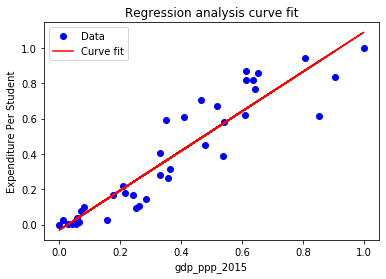

In [476]:
def fit_data_mat(df_data1, df_data2, degree, title, x_label, y_label):
    """Plot data from df_data1 and df_data2 and try to fit a curve with a given degree using matplotlib.pyplot
    :param df_data1: data frame
    :param df_data2: data frame
    :param degree: integer
    :param x_label: string
    :param y_label: string"""
    pylab.plot(df_data1, df_data2, 'bo', label='Data')
    pylab.title(title)
    pylab.xlabel(x_label)
    pylab.ylabel(y_label)
    model = pylab.polyfit(df_data1, df_data2, degree)
    est_y_vals = pylab.polyval(model, df_data1)
    pylab.plot(df_data1, est_y_vals, 'r', label='Curve fit')
    pylab.legend(loc='best')
    pylab.show()

#plot with curve
line_consolidated_df_1 = fit_data_mat(consolidated_df_1 ['gdp_ppp_2015'], consolidated_df_1 ['Expenditure Per Student'], 1,
                                       'Regression analysis curve fit', 'gdp_ppp_2015',
                                   'Expenditure Per Student')

In [483]:
consolidated_df_1

consolidated_df_1_2 = consolidated_df_1.rename(columns={"Expenditure Per Student": "exp_per_student"})

In [484]:
import statsmodels.formula.api as smf
#perform OLS 
model_consolidated_df_1 = smf.ols(formula='gdp_ppp_2015 ~ exp_per_student', data=consolidated_df_1_2).fit()
model_consolidated_df_1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           gdp_ppp_2015   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     238.3
Date:                Sun, 19 Apr 2020   Prob (F-statistic):           1.05e-17
Time:                        17:42:55   Log-Likelihood:                 34.836
No. Observations:                  39   AIC:                            -65.67
Df Residuals:                      37   BIC:                            -62.34
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0727      0.025      2.904      0.006       0.022       0.123
exp_per_student     0.7740      0.050     15.436      0.000       0.672       0.876
==============================================================================
Omnibus:                        6.246   Durbin-Watson:                   2.273
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                4.865
Skew:                           0.786   Prob(JB):                       0.0878
Kurtosis:                       3.721   Cond. No.                         3.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [485]:
from sklearn.model_selection import  train_test_split
from sklearn import preprocessing

X = consolidated_df_1_2[['exp_per_student']]

y = consolidated_df_1_2[['gdp_ppp_2015']]

X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.05, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.15, random_state=1)


In [486]:
from sklearn.model_selection import  train_test_split
from sklearn.metrics import r2_score 
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [487]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train,y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_train)

In [488]:
#training Data
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'% mean_squared_error(y_train, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% r2_score(y_train, y_pred))

Coefficients: 
 [[0.80344058]]
Mean squared error: 0.01
Coefficient of determination: 0.87


In [489]:
# Make predictions using the testing set
y_pred = regr.predict(X_val)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'% mean_squared_error(y_val, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% r2_score(y_val, y_pred))

Coefficients: 
 [[0.80344058]]
Mean squared error: 0.01
Coefficient of determination: 0.88


In [490]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

random_model = RandomForestRegressor(n_estimators =100,
 min_samples_split = 10,
 min_samples_leaf = 15,
 max_features= 'auto',
 max_depth = 20,
 bootstrap = True)
random_model.fit(X_train, y_train)
r2_score(y_train, random_model.predict(X_train))

C:\Users\rohit\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


-0.00011970001850136747

In [491]:
print('R2 score for training data' ,r2_score(y_train, random_model.predict(X_train)))
print('R2 score for test data',r2_score(y_test, random_model.predict(X_test)))

      
print('Root mean square error score on training set',np.sqrt(mean_squared_error(y_train,random_model.predict(X_train))))
print('Root mean square error score on test set',np.sqrt(mean_squared_error(y_test,random_model.predict(X_test))))


R2 score for training data -0.00011970001850136747
R2 score for test data -36.98085773695274
Root mean square error score on training set 0.2770984295001724
Root mean square error score on test set 0.21657893238300926


In [492]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [494]:
from sklearn.ensemble import RandomForestRegressor


random_model = RandomForestRegressor(n_estimators =200,
 min_samples_split = 5,
 min_samples_leaf = 4,
 max_features= 'auto',
 max_depth = 10,
 bootstrap = True)
random_model.fit(X_train, y_train)
r2_score(y_train, random_model.predict(X_train))

C:\Users\rohit\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


0.8733893742264441

In [495]:
print(r2_score(y_test, random_model.predict(X_test)))

rmse = np.sqrt(mean_squared_error(y_test,random_model.predict(X_test)))
print(rmse)

-10.075063917019355
0.11695180932456348


In [467]:
standardized_Y_df = pd.DataFrame(standardized_Y) 

In [469]:
standardized_Y_df

,0
0,-1.154758
1,-0.658453
2,0.741618
3,1.346847
4,-0.923545
5,-0.646259
6,-0.493968
7,-0.715981
8,0.708610
9,1.355756


In [468]:
standardized_X_df = pd.DataFrame(standardized_X) 

In [ ]:
def fit_data_mat(df_data1, df_data2, degree, title, x_label, y_label):
    """Plot data from df_data1 and df_data2 and try to fit a curve with a given degree using matplotlib.pyplot
    :param df_data1: data frame
    :param df_data2: data frame
    :param degree: integer
    :param x_label: string
    :param y_label: string"""
    pylab.plot(df_data1, df_data2, 'bo', label='Data')
    pylab.title(title)
    pylab.xlabel(x_label)
    pylab.ylabel(y_label)
    model = pylab.polyfit(df_data1, df_data2, degree)
    est_y_vals = pylab.polyval(model, df_data1)
    pylab.plot(df_data1, est_y_vals, 'r', label='Curve fit')
    pylab.legend(loc='best')
    pylab.show()

#plot with curve
lin_ave_gdp_ppp_log_lux = fit_data_mat(pisa_ave_gdp_ppp_log_lux ['gdp_ppp_log'], pisa_ave_gdp_ppp_log_lux ['ave_result'], 1,
                                       'Regression analysis curve fit (without Luxembourg)', 'GDP per capita (log)',
                                   'average test result (points)')

In [ ]:
def load_from_wbdata(countries, indicators, year_from, year_to):
    """Create data frame for given list of countries, indicators and dates using World Bank API
    :param countries: list of codes
    :param indicators: dict {ind_code : ind_name}
    :param year_from: starting year
    :param year_to: ending year
    :returns df_data: multi index data frame
    """
    data_date = (datetime.datetime(year_from, 1, 1), datetime.datetime(year_to, 1, 1))
    df_data = wbdata.get_dataframe(indicators, country=countries, data_date=data_date, convert_date=False)
    return df_data

In [ ]:
#read in file with student count for given countries
edu_indicators = {'SP.PRE.TOTL.IN':'pre_primary_pop', 'SP.PRM.TOTL.IN':'primary_pop', 'SP.SEC.LTOT.IN':'lower_sec_pop'}
basic_student_pop = load_from_wbdata(country_codes,edu_indicators, 2005)

In [242]:
def load_from_wbdata(countries, indicators, year_from, year_to):
    """Create data frame for given list of countries, indicators and dates using World Bank API
    :param countries: list of codes
    :param indicators: dict {ind_code : ind_name}
    :param year_from: starting year
    :param year_to: ending year
    :returns df_data: multi index data frame
    """
    data_date = (datetime.datetime(year_from, 1, 1), datetime.datetime(year_to, 1, 1))
    df_data = wbdata.get_dataframe(indicators, country=countries, data_date=data_date, convert_date=False)
    return df_data

#get GDP PPP data (NY.GDP.PCAP.PP.KD - GDP per capita, PPP (constant 2011 international $))
gdp_ppp = load_from_wbdata(                     
country_codes, {'NY.GDP.PCAP.PP.KD':'gdp_ppp_2015'}, 2015, 2015)

In [243]:
gdp_ppp

,gdp_ppp_2015
country,
Afghanistan,1766.593077
Angola,6644.857255
Albania,10970.321401
Argentina,19243.579469
Armenia,8171.832354
...,...
Samoa,5460.312292
"Yemen, Rep.",3108.764217
South Africa,12345.928804


In [204]:
len(country_codes)  

173

In [248]:
basic_edu_exp_2005 = basic_edu_exp.query('Time == 2005')

In [332]:
basic_edu_exp_2005[['AUS']]

KeyError: "None of [Index(['AUS'], dtype='object')] are in the [columns]"

In [315]:
basic_edu_exp_2005[['LOCATION == VAT']]

KeyError: "None of [Index(['LOCATION == VAT'], dtype='object')] are in the [columns]"

In [314]:
basic_edu_exp_2005_WO_VAT = basic_edu_exp_2005.query('LOCATION != VAT')  #[['Country']]

UndefinedVariableError: name 'VAT' is not defined

In [317]:
def get_codes_list(df_data):
    """Create a list of countries codes from column Code in df_data
    change code for OECD members from OAVG to OED
    :param df_data: data frame
    :returns codes_list: list"""
    codes_list = df_data['LOCATION'].tolist()
    #print(code_list)
#    codes_list.remove('OAVG')
#    codes_list.append('OED')
    return codes_list

#get list of countries, who took PISA test
countries_codes = get_codes_list(basic_edu_exp_2005)

In [325]:
countries_codes.remove('VAT')


In [326]:
countries_codes

['AUS',
 'AUT',
 'BEL',
 'CZE',
 'DNK',
 'FIN',
 'FRA',
 'HUN',
 'ISL',
 'IRL',
 'ITA',
 'JPN',
 'KOR',
 'MEX',
 'NLD',
 'NZL',
 'NOR',
 'POL',
 'PRT',
 'SVK',
 'ESP',
 'SWE',
 'CHE',
 'GBR',
 'USA',
 'ARG',
 'AZE',
 'BRB',
 'BLR',
 'BLZ',
 'BMU',
 'BTN',
 'BRA',
 'BGR',
 'CMR',
 'TCD',
 'CHL',
 'COL',
 'COG',
 'CUB',
 'CYP',
 'DOM',
 'SLV',
 'EST',
 'GMB',
 'GHA',
 'GTM',
 'HKG',
 'IND',
 'IRN',
 'ISR',
 'JAM',
 'JOR',
 'KAZ',
 'KWT',
 'KGZ',
 'LAO',
 'LTU',
 'MRT',
 'MUS',
 'MAR',
 'NAM',
 'NIC',
 'OMN',
 'PER',
 'PHL',
 'ROU',
 'RUS',
 'RWA',
 'VCT',
 'SEN',
 'SVN',
 'ZAF',
 'SWZ',
 'TJK',
 'THA',
 'TUN',
 'URY',
 'ZMB',
 'AGO',
 'BFA',
 'QAT',
 'TZA',
 'UKR',
 'BWA',
 'AUS',
 'AUT',
 'BEL',
 'CZE',
 'DNK',
 'FIN',
 'FRA',
 'HUN',
 'ISL',
 'IRL',
 'ITA',
 'JPN',
 'KOR',
 'MEX',
 'NLD',
 'NZL',
 'NOR',
 'POL',
 'PRT',
 'SVK',
 'ESP',
 'SWE',
 'CHE',
 'GBR',
 'USA',
 'BRB',
 'BLZ',
 'BEN',
 'BMU',
 'BTN',
 'BGR',
 'BFA',
 'BDI',
 'CMR',
 'CPV',
 'TCD',
 'CHL',
 'COL',
 'CUB',
 'CYP',


In [300]:
countries_codes.remove('VAT')

In [301]:
countries_codes

['AUS',
 'AUT',
 'BEL',
 'CZE',
 'DNK',
 'FIN',
 'FRA',
 'HUN',
 'ISL',
 'IRL',
 'ITA',
 'JPN',
 'KOR',
 'MEX',
 'NLD',
 'NZL',
 'NOR',
 'POL',
 'PRT',
 'SVK',
 'ESP',
 'SWE',
 'CHE',
 'GBR',
 'USA',
 'ARG',
 'AZE',
 'BRB',
 'BLR',
 'BLZ',
 'BMU',
 'BTN',
 'BRA',
 'BGR',
 'CMR',
 'TCD',
 'CHL',
 'COL',
 'COG',
 'CUB',
 'CYP',
 'DOM',
 'SLV',
 'EST',
 'GMB',
 'GHA',
 'GTM',
 'HKG',
 'IND',
 'IRN',
 'ISR',
 'JAM',
 'JOR',
 'KAZ',
 'KWT',
 'KGZ',
 'LAO',
 'LTU',
 'MRT',
 'MUS',
 'MAR',
 'NAM',
 'NIC',
 'OMN',
 'PER',
 'PHL',
 'ROU',
 'RUS',
 'RWA',
 'VCT',
 'SEN',
 'SVN',
 'ZAF',
 'SWZ',
 'TJK',
 'THA',
 'TUN',
 'URY',
 'ZMB',
 'AGO',
 'BFA',
 'QAT',
 'TZA',
 'UKR',
 'BWA',
 'AUS',
 'AUT',
 'BEL',
 'CZE',
 'DNK',
 'FIN',
 'FRA',
 'HUN',
 'ISL',
 'IRL',
 'ITA',
 'JPN',
 'KOR',
 'MEX',
 'NLD',
 'NZL',
 'NOR',
 'POL',
 'PRT',
 'SVK',
 'ESP',
 'SWE',
 'CHE',
 'GBR',
 'USA',
 'BRB',
 'BLZ',
 'BEN',
 'BMU',
 'BTN',
 'BGR',
 'BFA',
 'BDI',
 'CMR',
 'CPV',
 'TCD',
 'CHL',
 'COL',
 'CUB',
 'CYP',


In [328]:
def load_from_wbdata(countries, indicators, year_from, year_to):
    """Create data frame for given list of countries, indicators and dates using World Bank API
    :param countries: list of codes
    :param indicators: dict {ind_code : ind_name}
    :param year_from: starting year
    :param year_to: ending year
    :returns df_data: multi index data frame
    """
    data_date = (datetime.datetime(year_from, 1, 1), datetime.datetime(year_to, 1, 1))
    df_data = wbdata.get_dataframe(indicators, country=countries, data_date=data_date, convert_date=False)
    return df_data

#get GDP PPP data (NY.GDP.PCAP.PP.KD - GDP per capita, PPP (constant 2011 international $))
gdp_ppp = load_from_wbdata({'AUS',
 'AUT',
 'BEL',
 'CZE',
 'DNK',
 'FIN',
 'FRA',
 'HUN',
 'ISL',
 'IRL',
 'ITA',
 'JPN',
 'KOR',
 'MEX',
 'NLD',
 'NZL',
 'NOR',
 'POL',
 'PRT',
 'SVK',
 'ESP',
 'SWE',
 'CHE',
 'GBR',
 'USA',
 'ARG',
 'AZE',
 'BRB',
 'BLR',
 'BLZ',
 'BMU',
 'BTN',
 'BRA',
 'BGR',
 'CMR',
 'TCD',
 'CHL',
 'COL',
 'COG',
 'CUB',
 'CYP',
 'DOM',
 'SLV',
 'EST',
 'GMB',
 'GHA',
 'GTM',
 'HKG',
 'IND',
 'IRN',
 'ISR',
 'JAM',
 'JOR',
 'KAZ',
 'KWT',
 'KGZ',
 'LAO',
 'LTU',
 'MRT',
 'MUS',
 'MAR',
 'NAM',
 'NIC',
 'OMN',
 'PER',
 'PHL',
 'ROU',
 'RUS',
 'RWA',
 'VCT',
 'SEN',
 'SVN',
 'ZAF',
 'SWZ',
 'TJK',
 'THA',
 'TUN',
 'URY',
 'ZMB',
 'AGO',
 'BFA',
 'QAT',
 'TZA',
 'UKR',
 'BWA',
 'AUS',
 'AUT',
 'BEL',
 'CZE',
 'DNK',
 'FIN',
 'FRA',
 'HUN',
 'ISL',
 'IRL',
 'ITA',
 'JPN',
 'KOR',
 'MEX',
 'NLD',
 'NZL',
 'NOR',
 'POL',
 'PRT',
 'SVK',
 'ESP',
 'SWE',
 'CHE',
 'GBR',
 'USA',
 'BRB',
 'BLZ',
 'BEN',
 'BMU',
 'BTN',
 'BGR',
 'BFA',
 'BDI',
 'CMR',
 'CPV',
 'TCD',
 'CHL',
 'COL',
 'CUB',
 'CYP',
 'DOM',
 'SLV',
 'EST',
 'GMB',
 'GHA',
 'GTM',
 'HKG',
 'IND',
 'IRN',
 'ISR',
 'JAM',
 'JOR',
 'KWT',
 'LAO',
 'LSO',
 'LTU',
 'MDV',
 'MRT',
 'MUS',
 'MAR',
 'NAM',
 'NIC',
 'OMN',
 'PER',
 'PHL',
 'ROU',
 'RWA',
 'VCT',
 'SEN',
 'ZAF',
 'SWZ',
 'TZA',
 'TGO',
 'TUN',
 'URY',
 'ZMB',
 'AGO',
 'ARG',
 'BWA',
 'BRA',
 'COG',
 'MDG',
 'AUS',
 'AUT',
 'CZE',
 'DNK',
 'FIN',
 'FRA',
 'HUN',
 'ISL',
 'IRL',
 'ITA',
 'JPN',
 'KOR',
 'LUX',
 'MEX',
 'NLD',
 'NZL',
 'NOR',
 'POL',
 'PRT',
 'SVK',
 'SWE',
 'CHE',
 'GBR',
 'USA',
 'BLZ',
 'BMU',
 'BRA',
 'BGR',
 'CHL',
 'CUB',
 'CYP',
 'DOM',
 'SLV',
 'EST',
 'GMB',
 'GHA',
 'GTM',
 'IND',
 'IRN',
 'JAM',
 'JOR',
 'KWT',
 'LTU',
 'NIC',
 'OMN',
 'PHL',
 'ROU',
 'SEN',
 'SWZ',
 'URY',
 'AGO',
 'ARG',
 'COG'}
, {'NY.GDP.PCAP.PP.KD':'gdp_ppp_2015'}, 2015, 2015)

In [329]:
gdp_ppp

,gdp_ppp_2015
country,
Angola,6644.857255
Argentina,19243.579469
Australia,43970.803704
Austria,44197.540203
Azerbaijan,16828.990160
...,...
Uruguay,19945.034681
United States,53187.573374
St. Vincent and the Grenadines,10470.977616
